In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from transformers import RobertaTokenizer, RobertaModel
from datasets import Dataset
import torch
import torch.nn as nn
from tqdm import tqdm
!pip install --quiet bertopic
!pip install --quiet sentence-transformers
!pip install --quiet keybert

# import warnings
# warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2025-06-21 09:41:38.451530: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750498898.682311      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750498898.749487      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.2 MB/s eta 0:00:00
/kaggle/input/roberta_finetuned_meld/pytorch/fine-tuned_1/1/test_sent_emo.csv
/kaggle/input/roberta_finetuned_meld/pytorch/fine-tuned_1/1/dev_sent_emo.csv
/kaggle/input/roberta_finetuned_meld/pytorch/fi

In [2]:
# Path to CSVs
train_df = pd.read_csv('/kaggle/input/roberta_finetuned_meld/pytorch/fine-tuned_1/1/train_sent_emo.csv')
dev_df = pd.read_csv('/kaggle/input/roberta_finetuned_meld/pytorch/fine-tuned_1/1/dev_sent_emo.csv')
test_df = pd.read_csv('/kaggle/input/roberta_finetuned_meld/pytorch/fine-tuned_1/1/test_sent_emo.csv')
print(train_df.columns)
train_df.head()

Index(['Sr No.', 'Utterance', 'Speaker', 'Emotion', 'Sentiment', 'Dialogue_ID',
       'Utterance_ID', 'Season', 'Episode', 'StartTime', 'EndTime'],
      dtype='object')


,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,also I was the point person on my companys tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731"
1,2,You mustve had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442"
2,3,That I did. That I did.,Chandler,neutral,neutral,0,2,8,21,"00:16:23,442","00:16:26,389"
3,4,So lets talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,8,21,"00:16:26,820","00:16:29,572"
4,5,My duties? All right.,Chandler,surprise,positive,0,4,8,21,"00:16:34,452","00:16:40,917"


Longest dialogue by utterance count: Dialogue_ID 54 with 24 utterances
Longest dialogue by character count: Dialogue_ID 450 with 1566 characters


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Longest dialogue translates to 369 tokens


(array([223., 241., 224., 146., 121.,  49.,  26.,   5.,   2.,   1.]),
 array([1.0000e+00, 1.5750e+02, 3.1400e+02, 4.7050e+02, 6.2700e+02,
        7.8350e+02, 9.4000e+02, 1.0965e+03, 1.2530e+03, 1.4095e+03,
        1.5660e+03]),
 <BarContainer object of 10 artists>)

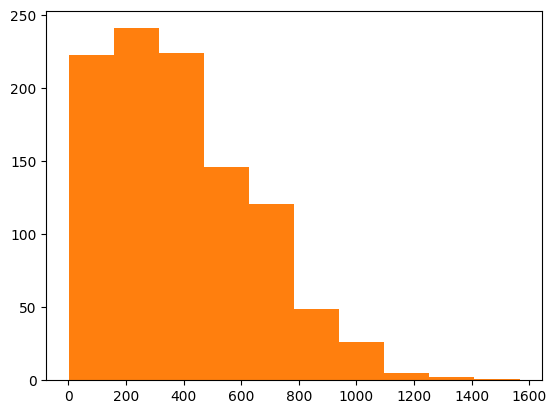

In [3]:
# Here I inspect the data for length. 
# We can see that we dont have a very long context window here
# Most utterances are short and 
grouped = train_df.groupby('Dialogue_ID')

# Dialogue with the most utterances
dialogue_lengths = grouped.size()
max_utterances_id = dialogue_lengths.idxmax()
max_utterances_count = dialogue_lengths.max()

# Dialogue with the most characters
dialogue_char_counts = grouped['Utterance'].apply(lambda x: sum(len(utt) for utt in x))
max_chars_id = dialogue_char_counts.idxmax()
max_chars_count = dialogue_char_counts.max()

print(f"Longest dialogue by utterance count: Dialogue_ID {max_utterances_id} with {max_utterances_count} utterances")
print(f"Longest dialogue by character count: Dialogue_ID {max_chars_id} with {max_chars_count} characters")

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
longest = " ".join(train_df[train_df['Dialogue_ID'] == max_utterances_id]['Utterance'].tolist())
tokens = tokenizer.tokenize(longest)
print(f'Longest dialogue translates to {len(tokens)} tokens')

plt.hist(dialogue_lengths)
plt.title('Dialogue Lengths')
plt.show()
plt.hist(dialogue_char_counts)
plt.title('Dialogue Character Counts')
plt.show()

In [4]:
model = RobertaModel.from_pretrained('roberta-base')
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
max_length = tokenizer.model_max_length

def build_dynamic_context_inputs(df):
    inputs = []
    labels = []

    for dialog_id in df['Dialogue_ID'].unique():
        dialog = df[df['Dialogue_ID'] == dialog_id].sort_values('Utterance_ID')
        utterances = dialog['Utterance'].tolist()
        speakers = dialog['Speaker'].tolist()
        emotions = dialog['Emotion'].tolist()

        # Create speaker mapping for this dialogue
        unique_speakers = sorted(set(speakers))
        speaker_map = {name: f"speaker{i+1}" for i, name in enumerate(unique_speakers)}

        for idx in range(len(utterances)):
            context = []
            token_count = 0
            
            # Start from current utterance and go backward
            for i in range(idx, -1, -1):
                speaker_tag = speaker_map[speakers[i]]
                text_piece = f"{speaker_tag}: {utterances[i]}"
                tokens = tokenizer.tokenize(text_piece)
                token_count += len(tokens) + 1  # +1 for separator

                if token_count >= max_length:
                    break

                context.insert(0, text_piece)  # prepend so order is preserved

            input_text = " </s> ".join(context)
            inputs.append(input_text)
            labels.append(emotions[idx])

    return inputs, labels

train_inputs, train_labels = build_dynamic_context_inputs(train_df)
test_inputs, test_labels = build_dynamic_context_inputs(test_df)
dev_inputs, dev_labels = build_dynamic_context_inputs(dev_df)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# Build new DataFrame from contextual inputs
label2id = {label: i for i, label in enumerate(sorted(set(train_labels)))} # Dict that maps each label to an integer
encoded_labels = [label2id[label] for label in train_labels]

# Now create the dataframe
data_dict = {
    "text": train_inputs,
    "label": encoded_labels
}
context_df = pd.DataFrame(data_dict)
train_dataset = Dataset.from_pandas(context_df)

# Function to tokenize the batch
def tokenize_batch(batch):
    return tokenizer(batch['text'],
                     padding='max_length',
                     truncation=True,
                     max_length=512,
                     return_attention_mask=True)

# Apply tokenizer
train_tokenized = train_dataset.map(tokenize_batch, batched=True, batch_size=32)

# Prepare for PyTorch
train_tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Now for the test set
test_label2id = {label: i for i, label in enumerate(sorted(set(test_labels)))} # Dict that maps each label to an integer
test_encoded_labels = [test_label2id[label] for label in test_labels]
test_data_dict = {
    "text": test_inputs,
    "label": test_encoded_labels
}
context_df = pd.DataFrame(test_data_dict)
test_dataset = Dataset.from_pandas(context_df)
test_tokenized = test_dataset.map(tokenize_batch, batched=True, batch_size=32)
test_tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# dev set
dev_label2id = {label: i for i, label in enumerate(sorted(set(dev_labels)))} # Dict that maps each label to an integer
dev_encoded_labels = [dev_label2id[label] for label in dev_labels]
dev_data_dict = {
    "text": dev_inputs,
    "label": dev_encoded_labels
}
context_df = pd.DataFrame(dev_data_dict)
dev_dataset = Dataset.from_pandas(context_df)
dev_tokenized = dev_dataset.map(tokenize_batch, batched=True, batch_size=32)
dev_tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


# Create dataloaders for train and dev sets (and maybe also test set)
from torch.utils.data import DataLoader
train_loader = DataLoader(train_tokenized, batch_size=16, shuffle=True)
dev_loader = DataLoader(dev_tokenized, batch_size=16)
test_loader = DataLoader(test_tokenized, batch_size=16)

Map:   0%|          | 0/9989 [00:00<?, ? examples/s]

dict_keys(['label', 'input_ids', 'attention_mask'])


Map:   0%|          | 0/2610 [00:00<?, ? examples/s]

Map:   0%|          | 0/1109 [00:00<?, ? examples/s]

In [6]:

# # Freeze all layers first
# for param in model.parameters():
#     param.requires_grad = False

# # Unfreeze last 2 layers of the encoder
# for layer in model.encoder.layer[-2:]:
#     for param in layer.parameters():
#         param.requires_grad = True

# # Define classification head
# class RobertaForEmotionClassification(nn.Module):
#     def __init__(self, model, num_labels):
#         super().__init__()
#         self.roberta = model
#         self.dropout = nn.Dropout(p=0.1)
#         self.classifier = nn.Linear(768, num_labels)

#     def forward(self, input_ids, attention_mask):
#         outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
#         cls_output = outputs.last_hidden_state[:, 0, :]  # CLS token
#         cls_output = self.dropout(cls_output)
#         return self.classifier(cls_output)

# # Instantiate model
# num_labels = len(set(train_labels))  # e.g. 7 emotions
# Full_model = RobertaForEmotionClassification(model, num_labels)


In [7]:
# # Load the trained model for F1 score
# model_path = "/kaggle/input/roberta_finetuned_meld/pytorch/fine-tuned_1/1/best_emotion_model_5.pt"
# checkpoint = torch.load(model_path, map_location=torch.device('cpu'))

# base_model = RobertaModel.from_pretrained("roberta-base")
# Full_model = RobertaForEmotionClassification(base_model, num_labels)
# Full_model.load_state_dict(checkpoint['model_state_dict'])
# Full_model.eval()

In [8]:
# # Finally we get to the Topic Modelling
# from sklearn.decomposition import PCA
# from sklearn.cluster import KMeans
# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd
# from tqdm import tqdm

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Full_model.to(device)
# Full_model.eval()

# all_embeddings = []

# with torch.no_grad():
#     for loader in [train_loader]:
#         for batch in tqdm(loader):
#             input_ids = batch['input_ids'].to(device)
#             attention_mask = batch['attention_mask'].to(device)

#             outputs = Full_model.roberta(input_ids=input_ids, attention_mask=attention_mask)
#             cls_embeds = outputs.last_hidden_state[:, 0, :]  # CLS token

#             all_embeddings.append(cls_embeds.cpu())

# # Combine all embeddings safely
# embeddings_np = torch.cat(all_embeddings, dim=0).numpy()


In [17]:
# Remove speaker tags from each of the datasets
import re
def remove_speaker_prefix(example):
    example['text'] = re.sub(r'speaker\d+:', '', example['text'], flags=re.IGNORECASE).strip()
    return example

test_dataset2 = test_dataset.map(remove_speaker_prefix)
train_dataset2 = train_dataset.map(remove_speaker_prefix)
dev_dataset2 = dev_dataset.map(remove_speaker_prefix)

Map:   0%|          | 0/2610 [00:00<?, ? examples/s]

Map:   0%|          | 0/9989 [00:00<?, ? examples/s]

Map:   0%|          | 0/1109 [00:00<?, ? examples/s]

In [24]:
# Now I create summaries before using the summaries with BERTopic to extract 
# Topics
from transformers import pipeline
from collections import defaultdict

# Load summarization pipeline (you can try T5 or Pegasus too)
# summarizer = pipeline("summarization", model="facebook/bart-large-cnn", device=0)  # use device=0 if GPU
summarizer = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6", device=0)

dialogue_texts = defaultdict(list)
for i, row in train_df.iterrows():
    dialogue_id = row['Dialogue_ID']
    utterance = row['Utterance']
    dialogue_texts[dialogue_id].append(utterance)

# Combine utterances into full dialogue text
documents = [" ".join(utterances) for utterances in dialogue_texts.values()]

summaries = []
for doc in documents:
    summary = summarizer(doc, truncation=True, max_length=300)[0]['summary_text']
    summaries.append(summary)

# Using BERTopic
from bertopic import BERTopic
topic_model = BERTopic(language="english", verbose=True)
topics, probs = topic_model.fit_transform(summaries)

# View topics
topic_model.get_topic_info()

Device set to use cuda:0
Your max_length is set to 300, but your input_length is only 173. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)
Your max_length is set to 300, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 300, but your input_length is only 97. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)
Your max_length is set to 300, but your input_length is only 87. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer(

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

2025-06-21 10:20:21,603 - BERTopic - Embedding - Completed ✓
2025-06-21 10:20:21,604 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-21 10:20:23,338 - BERTopic - Dimensionality - Completed ✓
2025-06-21 10:20:23,339 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-21 10:20:23,375 - BERTopic - Cluster - Completed ✓
2025-06-21 10:20:23,378 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-21 10:20:23,441 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,-1,312,-1_you_the_to_and,"[you, the, to, and, it, of, its, in, that, im]","[ Hi. Listen, Im sorry about that whole thing..."
1,0,144,0_chandler_phoebe_is_says,"[chandler, phoebe, is, says, she, to, you, the...","[ Chandler: ""I better not do any, I don't know..."
2,1,96,1_ross_to_says_rachel,"[ross, to, says, rachel, you, he, and, is, her...","[ My child has no father! Im sorry. Oh uh, I..."
3,2,74,2_joey_to_the_he,"[joey, to, the, he, says, you, with, and, for,...",[ Joey asked Pheebs if she wanted to go out wi...
4,3,55,3_oh_this_we_the,"[oh, this, we, the, you, no, im, all, so, to]","[ Hey! Hey! What are you guys doing up? Oh, we..."
5,4,48,4_monica_says_to_the,"[monica, says, to, the, she, in, and, you, so,...","[ Monica: ""If we were in prison, you guys woul..."
6,5,46,5_the_wait_you_it,"[the, wait, you, it, to, hes, oh, that, is, have]",[ Oh! Oh God Now you know how you really feel ...
7,6,44,6_she_says_to_im,"[she, says, to, im, it, not, going, get, sure,...","[ Oh, y, y'know.. Oh, I'm not sure what's goi..."
8,7,43,7_the_you_eat_it,"[the, you, eat, it, to, that, of, in, mon, like]","[ I'm not crazy, right? I mean, it was never l..."
9,8,28,8_wedding_married_you_we,"[wedding, married, you, we, and, to, is, have,...","[ Hey! Hey! Listen, I know you wanted to talk ..."


In [11]:
# View topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,994,0_you_the_to_and,"[you, the, to, and, it, that, is, im, he, in]",[Only an idiot would wear this stuff if you di...
1,1,44,1_gallery_snapshots_for_next,"[gallery, snapshots, for, next, of, visit, fea...",[CNN.com will feature iReporter photos in a we...


In [12]:
# try with sentense transformers
from sentence_transformers import SentenceTransformer
import numpy as np

model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight and effective

sentences = test_dataset2['text']  # or wherever your preprocessed utterances are

# Generate embeddings
embeddings = model.encode(sentences, show_progress_bar=True)


from sklearn.decomposition import PCA
pca = PCA(n_components=50)
embeddings_reduced = pca.fit_transform(embeddings)


from sklearn.cluster import KMeans
num_topics = 7  # You can tune this
kmeans = KMeans(n_clusters=num_topics, random_state=42)
clusters = kmeans.fit_predict(embeddings_reduced)

from collections import defaultdict
import pandas as pd
cluster_to_sentences = defaultdict(list)
for sent, cluster_id in zip(sentences, clusters):
    cluster_to_sentences[cluster_id].append(sent)

# View example clusters
for cluster_id, utts in cluster_to_sentences.items():
    print(f"\nCluster {cluster_id} (Top 5 sentences):")
    for utt in utts[:5]:
        print("-", utt)

Batches:   0%|          | 0/82 [00:00<?, ?it/s]


Cluster 0 (Top 5 sentences):
- Why do all youre coffee mugs have numbers on the bottom?
- Come on, Lydia, you can do it.
- Oh, okay, I get it.
- Oh, okay, I get it. </s>  No wait, look. Look! I'm sorry, it's just I've never even </s>  Howard's the </s>  Yes but too me he's just, man. </s>  Okay, fine, whatever. Welcome to the building. </s>  Ugh, can you believe that guy! </s>  Yeah. I really like his glasses.
- Ohh!

Cluster 5 (Top 5 sentences):
- Why do all youre coffee mugs have numbers on the bottom? </s>  Oh. Thats so Monica can keep track. That way if one on them is missing, she can be like, Wheres number 27?!
- Why do all youre coffee mugs have numbers on the bottom? </s>  Oh. Thats so Monica can keep track. That way if one on them is missing, she can be like, Wheres number 27?! </s>  Y'know what?
- Okay. </s>  Ross, didn't you say that there was an elevator in here?
- Okay. </s>  Ross, didn't you say that there was an elevator in here? </s>  Uhh, yes I did but there

In [13]:
# For the extraction of keywords
from keybert import KeyBERT
kw_model = KeyBERT(model=model)  # reuse your sentence-transformer

for cluster_id, texts in cluster_to_sentences.items():
    doc = " ".join(texts)
    keywords = kw_model.extract_keywords(doc, top_n=5)
    print(f"Cluster {cluster_id}: {keywords}")

Cluster 0: [('costumes', 0.4046), ('costume', 0.3915), ('mugs', 0.3583), ('fashion', 0.3111), ('underwear', 0.3047)]
Cluster 5: [('elevator', 0.3764), ('ross', 0.2979), ('mugs', 0.2974), ('monica', 0.2913), ('missing', 0.274)]
Cluster 6: [('lydia', 0.3987), ('push', 0.3962), ('pull', 0.3703), ('ball', 0.3665), ('pushing', 0.3659)]
Cluster 3: [('kicked', 0.3402), ('lips', 0.3352), ('bumpy', 0.3099), ('kick', 0.3078), ('lip', 0.3052)]
Cluster 1: [('kicked', 0.3513), ('tripped', 0.3467), ('overslept', 0.3302), ('break', 0.3288), ('elastic', 0.3173)]
Cluster 2: [('chandler', 0.4801), ('room', 0.3828), ('joey', 0.328), ('phoebe', 0.3189), ('chan', 0.2929)]
Cluster 4: [('fighting', 0.3362), ('room', 0.3191), ('fight', 0.3173), ('ross', 0.2845), ('silliness', 0.2831)]


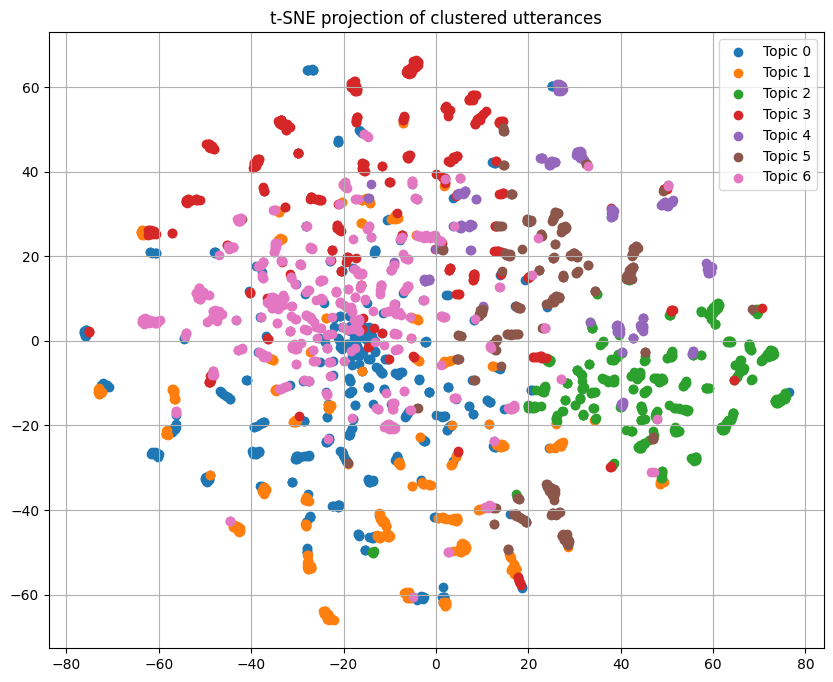

In [14]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Apply t-SNE to reduce embeddings to 2D
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
tsne_embeddings = tsne.fit_transform(embeddings_reduced)  # `embeddings_reduced` = PCA-reduced version

# Plot clusters
plt.figure(figsize=(10, 8))
for i in range(num_topics):  # or `n_clusters` if you're using KMeans
    plt.scatter(tsne_embeddings[clusters == i, 0], tsne_embeddings[clusters == i, 1], label=f"Topic {i}")

plt.legend()
plt.title("t-SNE projection of clustered utterances")
plt.grid(True)
plt.show()